## MO436 - Tópicos em Aprendizado de Máquina: Reinforcement Learning - 2s2020

### Projeto 1
Leandro Rebes Camargo, 150960 | Mauricio de Sousa Araujo, 184477 | Raysa Masson Benatti, 176483

#### Introdução

O objetivo deste trabalho é aplicar métodos de aprendizado por reforço para resolver um problema definido pelo grupo. No nosso caso, optamos por estudar e resolver o problema do <b>CartPole</b>. 
    
Conforme definido por Barto, Sutton e Anderson [[1]](#Referências), trata-se de um sistema simulado que representa um pêndulo invertido. Nessa simulação, o <b>agente</b> é um carrinho que se move em um trilho sem atrito de uma dimensão, para a esquerda ou direita; ligado ao carrinho, encontra-se uma estaca, que se move angularmente, em sentido horário ou anti-horário. O objetivo do problema é colocar o carrinho em movimento de modo que a estaca (pêndulo) permaneça ereta. 

Para atingir esse objetivo, devemos controlar as variáveis do modelo. São quatro variáveis, que definem os <b>estados</b> do sistema: (1) a posição <b>p</b> do carrinho no trilho; (2) a velocidade <b>v</b> do carrinho; (3) o ângulo <b>a</b> que a estaca forma com o eixo vertical do carrinho; (4) a velocidade angular <b>va</b> de movimento da estaca.

O modelo tem duas <b>ações</b> possíveis: movimentar o carrinho sobre o trilho para a esquerda ou para a direita.

Um estado desse sistema é <b>terminal</b> nas seguintes situações: (1) se o módulo do ângulo <b>a</b> é maior que 12 graus (o que representa, na prática, a queda da estaca); (2) se o centro do carrinho atinge alguma borda do ambiente; (3) se a quantidade máxima de episódios definida foi atingida. Os estados terminais (1) e (2) são considerados fracassos; o estado terminal (3) é bem-sucedido e representa o objetivo do problema <b>se</b>, quando é atingido, o carrinho se movimenta com a estaca ereta. Por padrão, a cada ação tomada, o ambiente fornece ao agente um <i>feedback</i> --- ou <b>recompensa</b> --- no valor de 1; se a ação resulta em um estado (1) ou (2), o ambiente enviará um <i>failure signal</i> através da variável booleana ``done``, cujo valor será modificado de ``False`` para ``True``. Caso a ação faça a estaca cair (estado (1)), a recompensa será zero.

O ambiente se caracteriza como <b>estocástico</b>, pois não é possível determinar o resultado a partir de um estado atual, e <b>não episódico</b>, pois as ações do agente são relacionadas (ações presentes afetam ações futuras). 


#### Visualização do ambiente

Para implementar e explorar o problema, usamos o ambiente CartPole-v0 do <i>toolkit</i> OpenAI Gym [[2]](#Referências). A execução do código abaixo importa o ambiente e as bibliotecas necessárias, além de plotar uma amostra de imagem do carrinho e seus arredores.

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [127]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import time
env = gym.make("CartPole-v0")

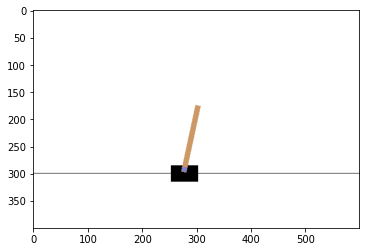

In [128]:
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample() 
    #0 = ir para trás, 1 = ir pra frente
    obs, reward, done, info = env.step(action) 
    #obs é um vetor com 4 valores: Position, Cart Velocity, Angle, Angle Velocity
    screen = env.render(mode='rgb_array')
    
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    
    if(done):
        break
    
ipythondisplay.clear_output(wait=True)
env.close()

#### Discretização

Para discretizar o ambiente, criamos uma classe ``Discretizer``, que recebe como parâmetros o limite inferior, o limite superior e a quantidade de <i>bins</i> a serem criados. Tais parâmetros podem ser customizados conforme o mais adequado para cada método, verificado experimentalmente. Cada uma das variáveis --- posição, velocidade, ângulo e velocidade angular --- é discretizada e usada para constituir um estado válido a partir da função ``gen_state``. O código abaixo implementa essa lógica e imprime 20 exemplos de estados válidos. 

In [129]:
class Discretizer:
    def __init__(self,nbins,lower,high):
        '''
        Discretizamos um intervalo que vai de lower até high em nbins. 
        Todos valores do lower receberam um mesmo valor de estado,
        assim como os acima de high
        '''
        self.nbins=nbins
        self.high=high
        self.lower=lower
        self.thresholds=np.array([])
        self.fit()
    def fit(self):
        step=(self.high-self.lower)/self.nbins 
        self.thresholds = np.arange(self.lower, self.high, step) 
    def transform(self,x):
        return np.digitize(x,self.thresholds)

position_discretizer = Discretizer(nbins = 1000 ,lower = env.observation_space.low[0], high = env.observation_space.high[0]) 
velocity_discretizer = Discretizer(nbins = 1000, lower = -100 , high = 100  ) 
angle_discretizer = Discretizer(nbins = 1000 ,lower = env.observation_space.low[2], high = env.observation_space.high[2])
velocity_angle_discretizer = Discretizer(nbins = 100, lower = -10 , high = 10) 

gen_state = lambda  p, v, a, va : ( position_discretizer.transform(p), velocity_discretizer.transform(v), 
                                    angle_discretizer.transform(a), velocity_angle_discretizer.transform(va) )

#Sample
#Position, Velocity, Angle, Velocity Angle
env.reset()
for i in range(20):
    action = env.action_space.sample() #0 ir para trás, 1 ir pra frente
    obs, reward, done= env.step(action)[:3] #obs é um vetor com 4 valores, Position, Cart Velocity, Angle, Angle Velocity
    p, v, a, va=obs
    print(gen_state(p,v,a,va)) #Discretiza e gera estados válidos

(498, 501, 498, 49)
(498, 502, 492, 48)
(499, 503, 478, 46)
(500, 504, 458, 45)
(502, 505, 430, 43)
(504, 506, 395, 42)
(506, 507, 353, 40)
(509, 506, 303, 41)
(512, 505, 259, 43)
(514, 506, 221, 41)
(516, 505, 175, 42)
(518, 504, 133, 43)
(520, 505, 97, 41)
(522, 504, 51, 42)
(523, 503, 10, 43)
(524, 504, 0, 41)
(526, 503, 0, 41)
(527, 503, 0, 42)
(528, 502, 0, 42)
(529, 501, 0, 43)


/home/ray/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Os limites inferior e superior das variáveis <b>posição</b> e <b>ângulo</b> são aqueles definidos como padrão no ambiente: $p \in [-4.8, 4.8]$ e $a \in [-24, 24]$ (em graus). As variáveis <b>velocidade</b> e <b>velocidade angular</b> têm limites infinitos; assim, devemos definir manualmente seus limites. Como padrão, escolhemos $v \in [-100, 100]$ e $va \in [-10, 10]$, além de uma discretização de 1000 <i>bins</i> para <b>p</b>, <b>v</b> e <b>a</b>, e de 100 <i>bins</i> para <b>va</b>.

#### Monte Carlo Control

#### Q-learning

O algoritmo Q-learning tem como objetivo aprender a função valor que melhor resolverá o problema no ambiente. A intiuição é que, dado um estado, o agente será informado sobre qual a melhor ação a ser tomada de modo a maximizar a expectativa de ganho futuro. O Q-learning pode ser definido canonicamente segundo a fórmula abaixo (Equação de Bellman), em que:
- $max_{a} Q(s_{t+1}, a)$ é a estimativa de valor ótimo futuro para uma ação $a$;
- $Q(s_{t}, a_{t})$ é a estimativa no estado $s_{t}$ atual;
- $\alpha$ é a taxa de aprendizado (<i>learning rate</i>), que varia de 0 a 1 e representa quão rápido o algoritmo aprende a função;
- $\gamma$ é o fator de desconto (<i>discount factor</i>), que varia de 0 a 1 e representa a proporção de importância dada à recompensa em longo prazo. 

\begin{equation}
Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha \cdot (r_{t} + \gamma \cdot max_{a} Q(s_{t+1}, a) - Q(s_{t}, a_{t}))
\end{equation}

O código abaixo, adaptado de Richard Brooker [[3]](#Referências), implementa essa lógica, seguindo os passos:
- Inicializar a ``Q_table`` com zeros; 
- Criar funções para: implementar a política gulosa de selecionar o maior valor Q da tabela; atualizar a função valor; definir uma taxa de aprendizado adaptativa, que diminui com o tempo; definir uma taxa de exploração adaptativa, que diminui com o tempo para gradativamente privilegiar exploitação;
- Definir os níveis de discretização;
- Definir a quantidade de episódios;
- Executar o modelo. 

Os parâmetros escolhidos para execução definitiva do modelo, determinados experimentalmente, são:
- Quantidade de <i>bins</i>: 10 para cada variável (para ordens de grandeza maiores, o armazenamento de ``Q_table`` se tornava impraticável);
- Domínios de variáveis padrão, exceto para velocidade angular, em que $va \in [-50, 50]$ (em radianos);
- 1000 episódios (iterações) (para ordens de grandeza maiores, o tempo de execução se tornava muito longo);
- Fator de desconto 1.

In [144]:
n_bins=(11,11,11,11)

#Inicializa tabela com zeros
Q_table = np.zeros(n_bins + (env.action_space.n,))
Q_table.shape

(11, 11, 11, 11, 2)

In [152]:
#Cria policy function; usa Q-table para selecionar o maior Q
def policy( state : tuple ):
    return np.argmax(Q_table[state])

#Atualiza função valor
def new_Q_value( reward : float ,  new_state : tuple , discount_factor=1 ) -> float:
    future_optimal_value = np.max(Q_table[new_state])
    learned_value = reward + discount_factor * future_optimal_value
    return learned_value

#Taxa de aprendizado adaptativa
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

#Taxa de exploração adaptativa; tradeoff exploração-exploitação
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [153]:
#Discretização
env.reset()

position_discretizer = Discretizer(nbins = 10 ,lower = env.observation_space.low[0], high = env.observation_space.high[0]) 
velocity_discretizer = Discretizer(nbins = 10, lower = -100 , high = 100  ) 
angle_discretizer = Discretizer(nbins = 10 ,lower = env.observation_space.low[2], high = env.observation_space.high[2])
velocity_angle_discretizer = Discretizer(nbins = 10, lower = -math.radians(50) , high = math.radians(50)) 

gen_state = lambda  p, v, a, va : ( position_discretizer.transform(p), velocity_discretizer.transform(v), 
                                   angle_discretizer.transform(a), velocity_angle_discretizer.transform(va) )

In [156]:
#Training e execução
n_episodes = 1000 
q_values = [] 

start_time = time.time()

for e in range(n_episodes):

    #Inicializamos com um estado
    env.reset()
    obs = env.step(env.action_space.sample())[0]
    p, v, a, va=obs
    current_state = gen_state(p,v,a,va) #Discretiza e gera estado válido

    done = False

    while done==False:
        
        # Policy action 
        action = policy(current_state) # exploit
        
        # Insere ação aleatória
        if np.random.random() < exploration_rate(e) : 
            action = env.action_space.sample() # explore 
         
        # Atualiza ambiente
        obs, reward, done, _ = env.step(action)
        p, v, a, va = obs
        new_state = gen_state(p,v,a,va)
        
        # Atualiza Q-Table
        lr = learning_rate(e)
        learnt_value = new_Q_value(reward , new_state)
        old_value = Q_table[current_state][action]
        Q_table[current_state][action] = (1-lr)*old_value + lr*learnt_value
        q_values.append(Q_table[current_state][action])
        
        current_state = new_state
        
        # Render do ambiente
        env.render()
        
    
end_time = time.time()
total_time = end_time - start_time
print("Tempo total de execução: {} segundos".format(total_time))

Tempo total de execução: 296.2074270248413 segundos


Abaixo, plotamos a variação dos valores de Q em função do tempo. O gráfico mostra que o algoritmo convergiu rapidamente para a solução.

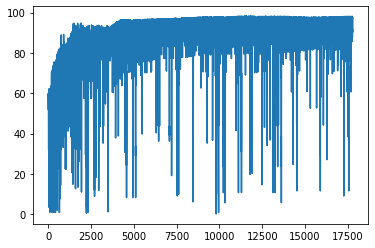

In [157]:
#episodes = np.arange(0, n_episodes, 1)
x = np.arange(0, len(q_values), 1)
plt.plot(x, q_values)
plt.show()

A visualização do comportamento do cartpole neste algoritmo, após convergência, encontra-se [neste vídeo](https://streamable.com/of543q).

#### SARSA

#### Aproximador de função linear

#### Síntese dos resultados e discussões

- <b>Comparação entre algoritmos</b>:

|           |Complexidade computacional|Tempo para execução e aprendizado| Resultado|
|-----------|--------------------------|---------------------------------|----------|
|Monte Carlo|--------------------------|---------------------------------|----------|
|Q-learning |Linear*|Execução total em 296 segundos (1000 episódios); aprendizado em aproximadamente 20% do tempo|Satisfatório, com convergência para solução|
|SARSA      |--------------------------|---------------------------------|----------|
|Aproximador|--------------------------|---------------------------------|----------|

\* O tempo de execução para 10.000 iterações foi aproximadamente 10 vezes maior que o tempo de execução para 1.000 iterações

- <b>Considerações sobre a função de recompensa</b>: Bla
- <b>Considerações sobre a função de aproximação linear</b>: Bla

#### Descrição das tarefas do grupo

Todos os membros do grupo participaram das etapas de definição/estudo do problema e discussões gerais. Além disso, cada um dos integrantes se debruçou sobre as seguintes tarefas: 

- Leandro:
- Mauricio:
- Raysa: Estudo, implementação e testes do algoritmo Q-learning; Escrita e organização do relatório (Introdução, Visualização do ambiente, Discretização, Q-learning, Síntese dos resultados e discussões, Referências). 

OBS.: o grupo foi originalmente constituído por quatro pessoas, conforme especificação, mas um dos membros abandonou a disciplina. 

#### Referências

[1] A. G. Barto, R. S. Sutton and C. W. Anderson, "Neuronlike adaptive elements that can solve difficult learning control problems," in <i>IEEE Transactions on Systems, Man, and Cybernetics</i>, vol. SMC-13, no. 5, pp. 834-846, Sept.-Oct. 1983, doi: 10.1109/TSMC.1983.6313077.

[2] OpenAI Gym: CartPole-v0. https://gym.openai.com/envs/CartPole-v0/ 

[3] Q-learning-demo-Cartpole-V1 by Richard Brooker. https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1